# Binary Classification (4/6)

In this notebook, after importing the necessary data and defining the class weights, we perform the following process in search of our model for the binary problem:
1) Find an underfitting and an overfitting model.
2) Do a grid search testing the parameters between the boundaries of the underfitting and overfitting model.
3) Perform cross validation on the model found.
4) Try some pretrained models, do transfer learning and fine-tuning.
5) Try some changes in the inputs and images to improve the results.
6) Evaluate our best model on the test set.

## Imports

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

#model selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

#preprocess
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

from keras.layers import Dense
from keras.optimizers import Adam,Adagrad,Adadelta,RMSprop
from keras.regularizers import L1, L2
from tensorflow.keras.regularizers import L1L2

# specifically for cnn
from keras.layers import Dropout, Flatten, Conv2D, MaxPooling2D, Input, concatenate

import tensorflow as tf
import kerastuner as kt

# tools
import os
%load_ext autoreload
%autoreload 2
from utils.tools import evaluate_model_train, evaluate_model_predictions, reg_wrapper, opt_wrapper, inception_module

# pre-trained model
from tensorflow.keras.applications import (
    ResNet50,
    InceptionV3, 
    DenseNet121,
    VGG16,
    Xception,
    VGG19,
    ResNet50V2,
    ResNet101,
    ResNet101V2,
    ResNet152V2,
    InceptionResNetV2,
    MobileNet,
    MobileNetV2,
    DenseNet169,
    DenseNet201,
    NASNetMobile,
    NASNetLarge,
    EfficientNetB0,
    EfficientNetB1,
    EfficientNetB2,
    EfficientNetB3,
    EfficientNetB4,
    EfficientNetB5,
    EfficientNetB6,
    EfficientNetV2B0)

In [ ]:
os.getcwd()

## Data

In [2]:
%cd ..

# labels
with open('./Data_Images/Ylabels_Bi_MC.pkl', 'rb') as file:  
    y_labels, _ = pickle.load(file)

# train
with open('./Data_Images/Train_HP_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_train_hp_a, y_binary_train_hp, _, Mag_train_hp = pickle.load(file)

# validaton
with open('./Data_Images/Val_HP_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_val_hp_a, y_binary_val_hp, _, Mag_val_hp = pickle.load(file)

# test
with open('./Data_Images/Test_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_test_a, y_binary_test, _, Mag_test = pickle.load(file)

# CV
with open('./Data_Images/Train_img_yEncode_Bi_MC_Mag.pkl', 'rb') as file:  
    X_train_a, y_binary_train, _, Mag_train = pickle.load(file)

# label encoder
with open('./Data_Images/LabelEncoder_Bi_MC.pkl', 'rb') as file:  
     label_encoder_binary, _= pickle.load(file)

c:\Users\Dinis RF\Desktop\DL_project-master\dlproject\DL_project


In [ ]:
class_weights_Bi = compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = {int(key):val for key, val in zip(label_encoder_binary.transform(np.unique(y_labels)),class_weights_Bi)}
class_weights_dict

{0: 1.5945564516129032, 1: 0.7284030208141462}

In [4]:
shape_input = X_train_hp_a.shape[1:]
shape_input

(150, 150, 3)

In [5]:
shape_mag = Mag_train_hp.shape[1:]
shape_mag

(4,)

## Binary Classification 

In [7]:
# for optaining identical results each time we run the notebooks
tf.random.set_seed(23)

### Base Model Underfitting

In [13]:
model_Bi_BMU = Sequential()
model_Bi_BMU.add(Conv2D(4, (5,5), activation='relu', input_shape=shape_input))
model_Bi_BMU.add(MaxPooling2D((2,2)))
model_Bi_BMU.add(Flatten())
model_Bi_BMU.add(Dense(8, activation='relu'))
model_Bi_BMU.add(Dropout(0.5))
model_Bi_BMU.add(Dense(2, activation='softmax'))
model_Bi_BMU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['F1Score'])
model_Bi_BMU.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 4)    │           304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 21316)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │       170,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 170,858 (667.41 KB)

 Trainable params: 170,858 (667.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_Bi_BMU=model_Bi_BMU.fit(X_train_hp_a, y_binary_train_hp, batch_size= 100, epochs=50, callbacks=list_callbacks, 
                                validation_data=[X_val_hp_a, y_binary_val_hp], class_weight=class_weights_dict)         

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - F1Score: 0.5805 - loss: 0.6607 - val_F1Score: 0.7731 - val_loss: 0.5244 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - F1Score: 0.6253 - loss: 0.5877 - val_F1Score: 0.7359 - val_loss: 0.5714 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - F1Score: 0.7130 - loss: 0.5910 - val_F1Score: 0.8052 - val_loss: 0.5276 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - F1Score: 0.7153 - loss: 0.5781 - val_F1Score: 0.7985 - val_loss: 0.5125 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - F1Score: 0.7035 - loss: 0.5852 - val_F1Score: 0.8249 - val_loss: 0.4672 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - F1Score: 0.7320 - loss: 0.5560 - val_F1Score: 0.7750 - val_loss: 0.4951 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - F1Score: 0.7099 - loss: 0.5829 - val_F1Score: 0.8350 

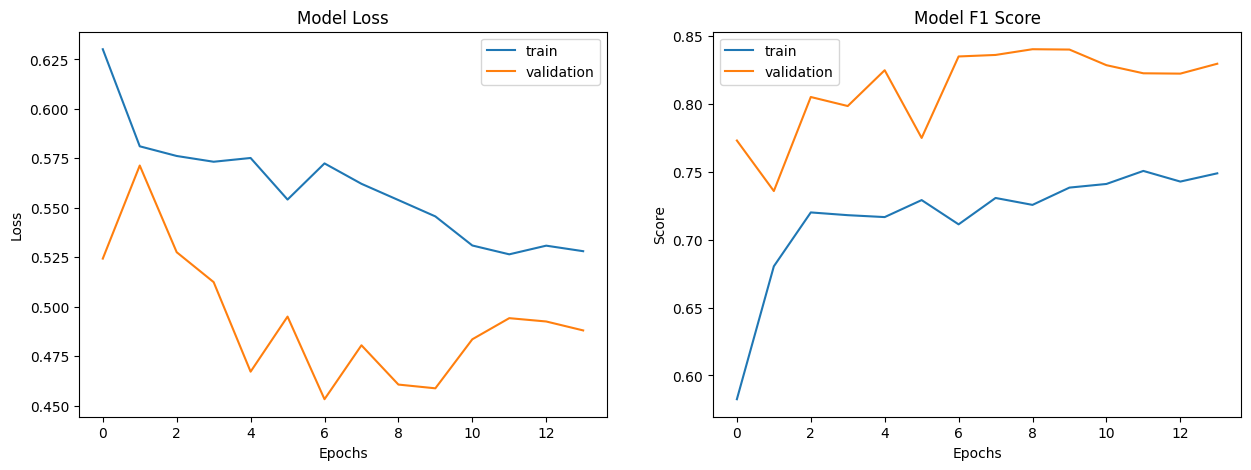

In [16]:
evaluate_model_train(history_Bi_BMU)

This model is obviously under fitting since the scores on the validation data are better than on the train data.

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

      benign       0.86      0.69      0.76       396
   malignant       0.87      0.95      0.91       870

    accuracy                           0.87      1266
   macro avg       0.86      0.82      0.84      1266
weighted avg       0.87      0.87      0.86      1266



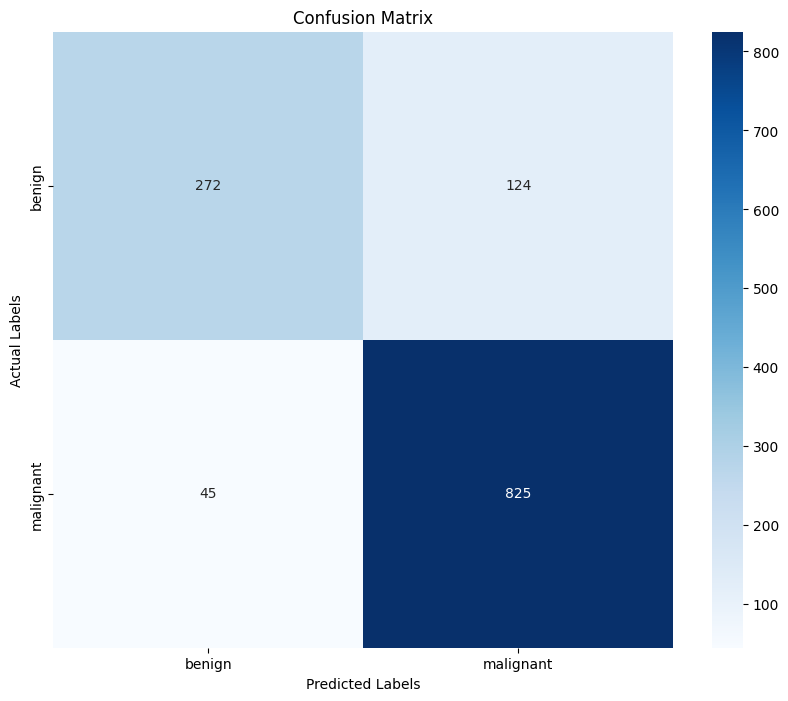

In [17]:
# of validation
evaluate_model_predictions(model_Bi_BMU, X_val_hp_a, y_binary_val_hp, y_labels, problem_type='single')

### Base Model Overfitting

In [ ]:
model_Bi_BMO = Sequential()
model_Bi_BMO.add(Conv2D(32, (7, 7), activation='relu', input_shape=shape_input))
model_Bi_BMO.add(Conv2D(32, (7, 7), activation='relu'))
model_Bi_BMO.add(MaxPooling2D((6, 6)))
model_Bi_BMO.add(Flatten())
model_Bi_BMO.add(Dense(128, activation='relu'))
model_Bi_BMO.add(Dense(64, activation='relu'))
model_Bi_BMO.add(Dense(2, activation='softmax'))

model_Bi_BMO.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['F1Score'])
model_Bi_BMO.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 144, 144, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 138, 138, 32)        │          50,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 16928)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,166,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,230,242 (8.51 MB)

 Trainable params: 2,230,242 (8.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_Bi_BMO=model_Bi_BMO.fit(X_train_hp_a, y_binary_train_hp, batch_size= 100, epochs=50, callbacks=list_callbacks,
                                validation_data=[X_val_hp_a, y_binary_val_hp], class_weight=class_weights_dict)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 48s 621ms/step - F1Score: 0.4282 - loss: 0.9610 - val_F1Score: 0.2383 - val_loss: 0.6968 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 181ms/step - F1Score: 0.2426 - loss: 0.6972 - val_F1Score: 0.4073 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - F1Score: 0.3176 - loss: 0.6981 - val_F1Score: 0.2383 - val_loss: 0.6937 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - F1Score: 0.3017 - loss: 0.6995 - val_F1Score: 0.4073 - val_loss: 0.6920 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 178ms/step - F1Score: 0.4329 - loss: 0.7000 - val_F1Score: 0.4073 - val_loss: 0.6921 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 182ms/step - F1Score: 0.4479 - loss: 0.6907 - val_F1Score: 0.4073 - val_loss: 0.6931 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 183ms/step - F1Score: 0.4675 - loss: 0.6966 - val_F1S

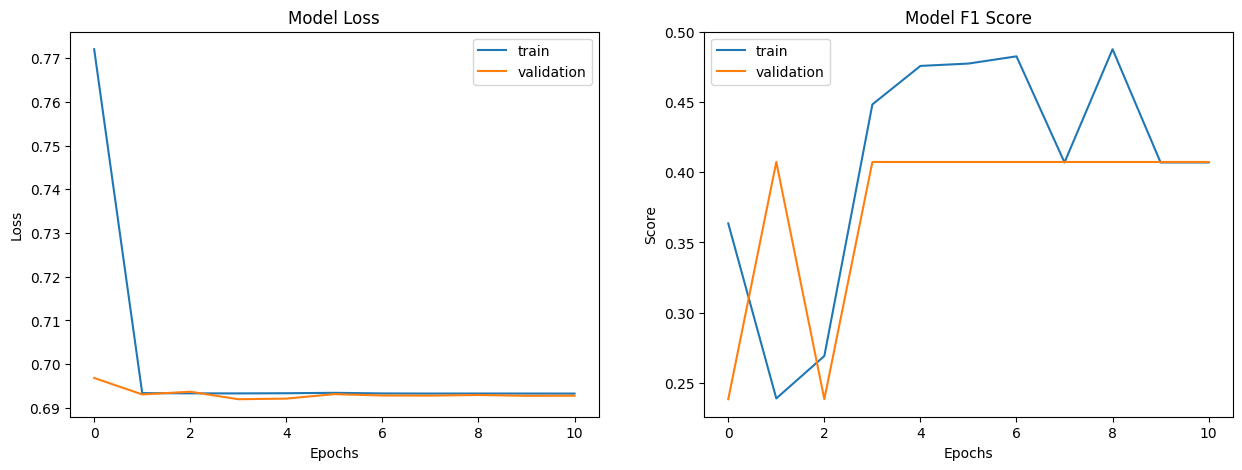

In [ ]:
evaluate_model_train(history_Bi_BMO)

The model is clearly overfitting even though it is a bit simpler, we will try to see more complex architectures in the gridsearch to see if we can increase the scores and then see if we reduce the overfitting and increase the results.

40/40 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step
              precision    recall  f1-score   support

      benign       0.00      0.00      0.00       396
   malignant       0.69      1.00      0.81       870

    accuracy                           0.69      1266
   macro avg       0.34      0.50      0.41      1266
weighted avg       0.47      0.69      0.56      1266



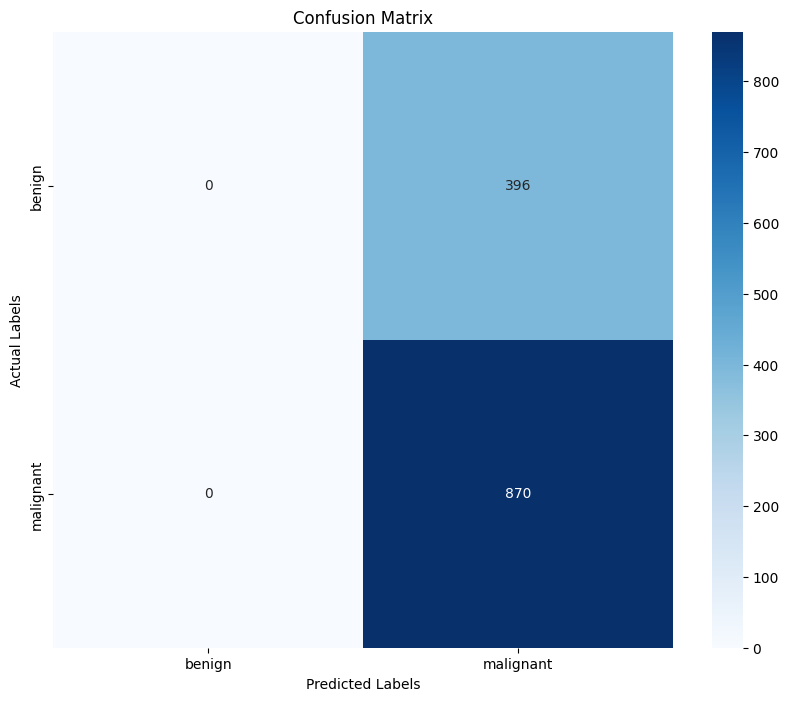

In [ ]:
evaluate_model_predictions(model_Bi_BMO, X_val_hp_a, y_binary_val_hp, y_labels, problem_type='single')

### Gridsearch

We will implement a grid search that follows a similar structure to the <a href="https://medium.com/@RaghavPrabhu/cnn-architectures-lenet-alexnet-vgg-googlenet-and-resnet-7c81c017b848">VGG architecture</a>, where we can have groups of convolution layers of the same size following by pooling layers. We will try:
+ Different numbers of conv blocks.
+ Filters of different sizes, strides, padding and number of filters, 
+ Different pooling sizes and strides.
+ Different number of layers and neuros.
+ Different values for dropout.
+ Different regularizes, activation functions and learning rates.

In [ ]:
def build_model_binary(hp):
    """
    Builds model and sets up hyperparameter space to search.

    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.

    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    
    # Initialize sequential model and start building model.
    model = Sequential()
    # Tune the number of Convolution blocks
    num_conv_blocks = hp.Int("num_conv_blocks", min_value=1, max_value=3)
    regularizer = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', [0.001, 0.01, 0.0]))
    for i in range(1, num_conv_blocks):
        filter_size = hp.Int('filter_size_' + str(i),min_value=3, max_value=7, step=2)
        strides_conv=hp.Int('stride_conv' + str(i), min_value=1, max_value=2)
        n_filters=hp.Int('n_filters_' + str(i), min_value=16, max_value=64, step=24)
        padding_conv=hp.Choice('padding_conv' + str(i), values=['same', 'valid'])
        # Tune the number of layers in each Convolution block
        conv_block_size = hp.Int("size_conv_block" + str(i), min_value=2, max_value=3)
        for k in range(1, conv_block_size):
            model.add(Conv2D(filters=n_filters,
                         kernel_size=filter_size,
                         strides=strides_conv,
                         padding=padding_conv))
        pooling_size = hp.Int('Pooling_size' + str(i),min_value=2, max_value=4)
        strides_pool=hp.Int('stride_pool' + str(i), min_value=1, max_value=2)
        model.add(MaxPooling2D(pool_size=pooling_size,
                               strides=strides_pool))
    # Tune the number of hidden layers and units in each.
    model.add(Flatten())
    # The basic for loop for including several layers
    for j in range(1, hp.Int("num_layers", min_value=2, max_value=4)):  
        units = hp.Int("units_" + str(j), min_value=32, max_value=512, step=100)
        model.add(Dense(units=units,
                        activation="relu",
                        kernel_regularizer=regularizer))
        # Dropout following the previous dense layer means that after each layer we would have a dropout
        # Tune dropout layer with values from 0 - 0.5 with stepsize of 0.1.
        dropout = hp.Float("dropout_" + str(j), min_value=0, max_value=0.5, step=0.2)
        model.add(Dropout(dropout))

    # Add output layer.
    model.add(Dense(2, activation='softmax'))

    # Tune learning rate for Adam optimizer with values from 0.01, 0.001
    hp_learning_rate = hp.Choice("learning_rate", values=[0.01, 0.001])

    # You can change the optimizer to others (ADPOT is not in keras nor tensorflow)
    hp_optimizer = hp.Choice("Optimizer", values=['Adam', 'Adagrad', 'Adadelta', 'RMSprop'])

    # Define optimizer, loss, and metrics
    model.compile(optimizer=opt_wrapper(hp_optimizer, hp_learning_rate),
                  loss='categorical_crossentropy',
                  metrics=["F1Score"])

    return model

Using hyperband from keras tuner to find the best model.

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
tuner_binary = kt.Hyperband(build_model_binary, # the hypermodel
                     objective='val_loss',  # Our main monitoring metric
                     max_epochs=50,
                     factor=10, # factor which you have seen above
                     directory='.\logs', # directory to save logs
                     project_name = 'HP_Bi_1', # You can name the project itself
                     seed=42) 

Reloading Tuner from /logs\HP_Bi_1\tuner0.json


In [ ]:
tuner_binary.search(X_train_hp_a, y_binary_train_hp, epochs=50, validation_data=[X_val_hp_a, y_binary_val_hp], 
                    callbacks=list_callbacks, class_weight=class_weights_dict)

In [12]:
best_parameters_binary= tuner_binary.get_best_hyperparameters()[0]
print(best_parameters_binary.values)

{'num_conv_blocks': 2, 'type': 'l2', 'reg_value': 0.01, 'num_layers': 2, 'learning_rate': 0.001, 'Optimizer': 'Adam', 'filter_size_1': 5, 'stride_conv1': 1, 'n_filters_1': 16, 'padding_conv1': 'valid', 'size_conv_block1': 3, 'Pooling_size1': 4, 'stride_pool1': 2, 'units_1': 132, 'dropout_1': 0.2, 'filter_size_2': 5, 'stride_conv2': 2, 'n_filters_2': 48, 'padding_conv2': 'same', 'size_conv_block2': 2, 'Pooling_size2': 3, 'stride_pool2': 1, 'units_2': 232, 'dropout_2': 0.0, 'tuner/epochs': 50, 'tuner/initial_epoch': 5, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0006', 'units_3': 232, 'dropout_3': 0.2}


That was the configuration of the best model found, we are not going to analyze the architecture yet since we don’t know if it is good or bad, the important part here is that the best optimizer was Adam so it will be the optimizer that we will use for our next models.

Now we will evaluate it using cross-validation.

In [ ]:
# Define per-fold score containers
f1_per_fold = []
loss_per_fold = []
history_per_fold = []

# Define the Cross Validator
kfold= StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Cross Validation model evaluation
fold_no = 1

for train, val in kfold.split(X_train_a, np.argmax(y_binary_train, axis=1)):

        early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
        LR_ajust = ReduceLROnPlateau(monitor="val_loss",factor=0.1, patience=3)

        list_callbacks = [early_stop, LR_ajust]

        X_train = X_train_a[train]
        y_train = y_binary_train[train]
        X_val = X_train_a[val]
        y_val = y_binary_train[val]
        # Define the model architecture

        model= tuner_binary.hypermodel.build(best_parameters_binary)

        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        # Fit data to model and store the losses per fold during training
        history = model.fit(X_train, y_train,
                batch_size=100,
                epochs=50,
                validation_data=[X_val, y_val],
                verbose=1, callbacks=list_callbacks,
                class_weight=class_weights_dict
        )
        history_per_fold.append(history.history['loss'])

        # Generate generalization metrics and evaluate on the k-1 fold
        scores = model.evaluate(X_val, y_val, verbose=1)
        print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
        f1_per_fold.append(scores[1])
        loss_per_fold.append(scores[0])

        # Increase fold number
        fold_no = fold_no + 1

        del X_train, y_train, X_val, y_val, model, history

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 284ms/step - F1Score: 0.5693 - loss: 8.2079 - val_F1Score: 0.8107 - val_loss: 1.8481 - learning_rate: 0.0010
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 21s 372ms/step - F1Score: 0.7646 - loss: 1.6189 - val_F1Score: 0.8104 - val_loss: 1.0026 - learning_rate: 0.0010
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 25s 447ms/step - F1Score: 0.7620 - loss: 0.9477 - val_F1Score: 0.8040 - val_loss: 0.7075 - learning_rate: 0.0010
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 30s 525ms/step - F1Score: 0.7561 - loss: 0.7112 - val_F1Score: 0.8068 - val_loss: 0.5979 - learning_rate: 0.0010
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 44s 776ms/step - F1Score: 0.7679 - loss: 0.6055 - val_F1Score: 0.8167 - val_loss: 0.5148 - learning_rate: 0.0010
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 53s 260ms/step - F1Score: 0.7713 - loss: 0.5465 - val_F1Score: 0.8176 - val_loss: 0.5034 - learning_rate: 0.00

In [14]:
#Provide average scores
print('Score per fold')
for i in range(0, len(f1_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - F1 Score: {round(float(np.mean(f1_per_fold[i])),4)}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> F1 Score: {round(float(np.mean(f1_per_fold)),4)} (+- {np.std(f1_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.4098895490169525 - F1 Score: 0.8291
------------------------------------------------------------------------
> Fold 2 - Loss: 0.4151768088340759 - F1 Score: 0.8079
------------------------------------------------------------------------
> Fold 3 - Loss: 0.4064744710922241 - F1 Score: 0.8167
------------------------------------------------------------------------
> Fold 4 - Loss: 0.45818889141082764 - F1 Score: 0.7757
------------------------------------------------------------------------
> Fold 5 - Loss: 0.43531906604766846 - F1 Score: 0.824
------------------------------------------------------------------------
> Fold 6 - Loss: 0.39044609665870667 - F1 Score: 0.8325
------------------------------------------------------------------------
> Fold 7 - Loss: 0.40597832202911377 - F1 Score: 0.8173
------------------------------------------------------------------------
> Fold 8 - Lo

The result of this model is worse than our benchmark (benchmark is 0.85 F1 score in validation), we will see the results of the pretrained model to decide if it is can beat the benchmark.

### Pre-Trained Model

Firstly, we will try different architectures and depths of the neural networks (provided by <a href="https://keras.io/api/applications/#usage-examples-for-image-classification-models"> keras</a>); we will use the weights of the ImageNet competition since training a network as big as these is very computationally consuming and we didn’t find weights for a task more in line with ours.

In [ ]:
models_to_test = [ResNet50, InceptionV3, DenseNet121,
 VGG16, Xception,VGG19,ResNet50V2,ResNet101,ResNet101V2,ResNet152V2,InceptionResNetV2,MobileNet,MobileNetV2,DenseNet169,DenseNet201,
 NASNetMobile,NASNetLarge,EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,EfficientNetB4,EfficientNetB5,
 EfficientNetB6,EfficientNetV2B0]

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

# Logging results
results = {}

# Iterate through models
for model_func in models_to_test:
    print(f"Model {model_func.__name__}")
        
    base_model = model_func(weights='imagenet', include_top=False, input_shape=shape_input)
        
    # Freeze layers
    for layer in base_model.layers:
        layer.trainable = False
        
    # Build the complete model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(2, activation='softmax')
        ])
        
    # Compile model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['F1Score'])
        
    history_PT_Bi = model.fit(X_train_hp_a, y_binary_train_hp, batch_size= 100, epochs=50, callbacks=list_callbacks, 
                              validation_data=[X_val_hp_a, y_binary_val_hp], class_weight=class_weights_dict)
        
    val_f1 = np.max(np.mean(history_PT_Bi.history['val_F1Score'], axis=1))
    print(history_PT_Bi.history['val_F1Score'])
    print(f"Model {model_func.__name__} achieved {val_f1:.4f} F1-score on validation data.")
    results[model_func.__name__] = val_f1

Model ResNet50
Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - F1Score: 0.4830 - loss: 0.8538 - val_F1Score: 0.3345 - val_loss: 0.7874 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - F1Score: 0.5134 - loss: 0.7159 - val_F1Score: 0.2779 - val_loss: 1.0500 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 197s 4s/step - F1Score: 0.5209 - loss: 0.7037 - val_F1Score: 0.2803 - val_loss: 1.0715 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - F1Score: 0.5326 - loss: 0.6920 - val_F1Score: 0.3066 - val_loss: 0.9189 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 186s 4s/step - F1Score: 0.5445 - loss: 0.6704 - val_F1Score: 0.6806 - val_loss: 0.6049 - learning_rate: 1.0000e-04
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 218s 4s/step - F1Score: 0.6247 - loss: 0.6380 - val_F1Score: 0.6778 - val_loss: 0.6053 - learning_rate: 1.0000e-04
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - F1Score: 0.6331 - loss: 0.6363 

In [ ]:
results

{'ResNet50': 0.7034137,
 'InceptionV3': 0.778231,
 'DenseNet121': 0.8598267,
 'VGG16': 0.79131716,
 'Xception': 0.7872389,
 'VGG19': 0.77105474,
 'ResNet50V2': 0.8582835,
 'ResNet101': 0.6519053,
 'ResNet101V2': 0.84570044,
 'ResNet152V2': 0.8297804,
 'InceptionResNetV2': 0.80024934,
 'MobileNet': 0.8127881,
 'MobileNetV2': 0.7743579,
 'DenseNet169': 0.85506535,
 'DenseNet201': 0.85068655,
 'NASNetMobile': 0.84115976,
 'NASNetLarge': 0.7237082,
 'EfficientNetB0': 0.23826712,
 'EfficientNetB1': 0.26239485,
 'EfficientNetB2': 0.40730333,
 'EfficientNetB3': 0.35301098,
 'EfficientNetB4': 0.23826712,
 'EfficientNetB5': 0.5362152,
 'EfficientNetB6': 0.43280274,
 'EfficientNetV2B0': 0.40730333}

Some models obtained good results (around 0.8 F1 score), but these are not better than our benchmark (0.88 in F1 score in validation), so we will continue with the best one for now, that is the DenseNet121 and tune the network parameters to see if we can beat the score.

We will start by unfreezing the last conv to finetune it and see the results.

In [9]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, min_lr = 0.00001)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
model = Sequential([base_model,
                    Flatten(),
                    Dropout(0.4),
                    Dense(128, activation='relu'),
                    Dropout(0.3),
                    Dense(64, activation='relu'),
                    Dense(2, activation='softmax')])

# Compile model
model.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['F1Score'])

history_PT_Bi = model.fit(X_train_hp_a, y_binary_train_hp, batch_size= 100, epochs=50, callbacks=list_callbacks, 
                          validation_data=[X_val_hp_a, y_binary_val_hp], class_weight=class_weights_dict)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - F1Score: 0.5769 - loss: 1.1592 - val_F1Score: 0.7956 - val_loss: 0.5030 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - F1Score: 0.7566 - loss: 0.4938 - val_F1Score: 0.8425 - val_loss: 0.3771 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - F1Score: 0.7998 - loss: 0.4303 - val_F1Score: 0.8300 - val_loss: 0.3908 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - F1Score: 0.8247 - loss: 0.3538 - val_F1Score: 0.8489 - val_loss: 0.3256 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - F1Score: 0.8607 - loss: 0.3134 - val_F1Score: 0.8435 - val_loss: 0.3413 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - F1Score: 0.8660 - loss: 0.2813 - val_F1Score: 0.8723 - val_loss: 0.2986 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - F1Score: 0.8842 - loss: 0.2516 - val_F1Score: 0.8519 - val_l

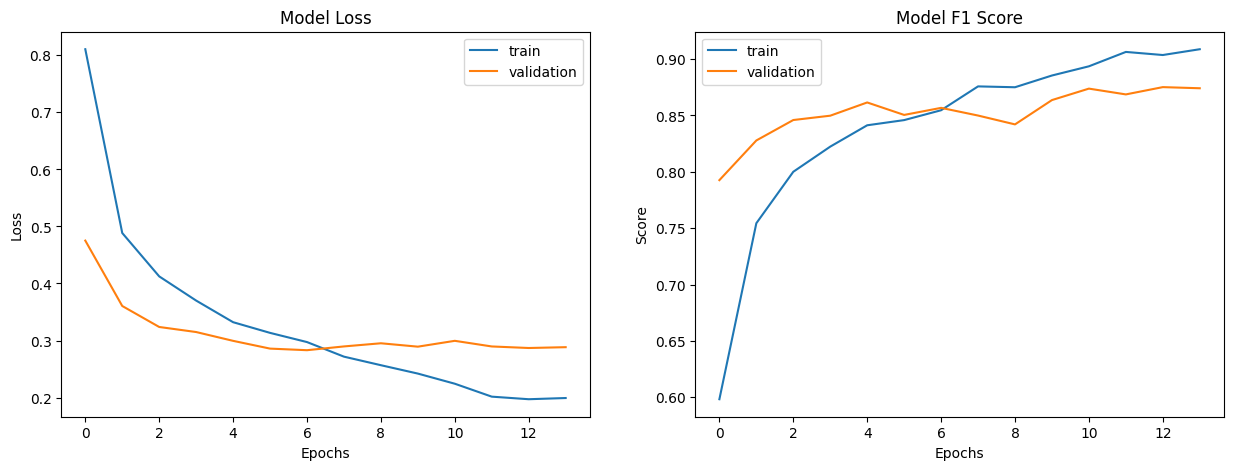

In [14]:
evaluate_model_train(history_PT_Bi)

40/40 ━━━━━━━━━━━━━━━━━━━━ 24s 527ms/step
              precision    recall  f1-score   support

      benign       0.83      0.82      0.83       396
   malignant       0.92      0.92      0.92       870

    accuracy                           0.89      1266
   macro avg       0.88      0.87      0.87      1266
weighted avg       0.89      0.89      0.89      1266



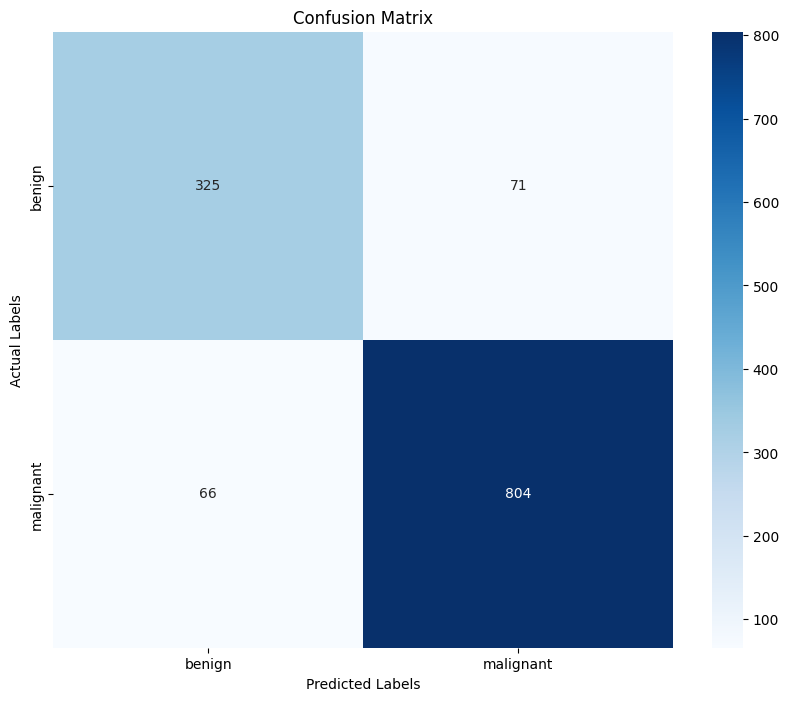

In [11]:
evaluate_model_predictions(model, X_val_hp_a, y_binary_val_hp, y_labels, problem_type='single')

With this configuration, the F1 score in the validation is 0.87 (a little less than the benchmark of 0.88 F1 score in validation), still better than the one found in the grid search, but is has a little overfitting, so we will test if image data generator helps with that and to increase the scores.

### Best Model

We know the best model is the:

```plaintext
base_model = DenseNet121(weights='imagenet', 
                         include_top=False,                 input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
best_model = Sequential([base_model,
                         Flatten(),
                         Dropout(0.4),
                         Dense(128, activation='relu'),
                         Dropout(0.3),
                         Dense(64, activation='relu'),
                         Dense(2, activation='softmax')])

# Compile model
best_model.compile(optimizer= Adam(0.001), 
                   loss='categorical_crossentropy',      
                   metrics=['F1Score'])
```
Now we will test some variants of the implementation.


#### Using the Image Data Generator

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
best_model = Sequential([base_model,
                         Flatten(),
                         Dropout(0.4),
                         Dense(128, activation='relu'),
                         Dropout(0.3),
                         Dense(64, activation='relu'),
                         Dense(2, activation='softmax')])

# Compile model
best_model.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['F1Score'])


In [ ]:
datagen = ImageDataGenerator(rotation_range=50,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

datagen.fit(X_train_hp_a)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr = 0.00001)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_BM = best_model.fit(datagen.flow(X_train_hp_a, y_binary_train_hp, batch_size=100), epochs=50, callbacks=list_callbacks,
                            validation_data=[X_val_hp_a, y_binary_val_hp], class_weight=class_weights_dict)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - F1Score: 0.5000 - loss: 2.1629 - val_F1Score: 0.7085 - val_loss: 0.6018 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 560ms/step - F1Score: 0.6779 - loss: 0.5866 - val_F1Score: 0.7928 - val_loss: 0.4546 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 556ms/step - F1Score: 0.7386 - loss: 0.4946 - val_F1Score: 0.8108 - val_loss: 0.4005 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 44s 616ms/step - F1Score: 0.7658 - loss: 0.4647 - val_F1Score: 0.8131 - val_loss: 0.3753 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 38s 570ms/step - F1Score: 0.7721 - loss: 0.4552 - val_F1Score: 0.8085 - val_loss: 0.3999 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 578ms/step - F1Score: 0.7777 - loss: 0.4335 - val_F1Score: 0.8035 - val_loss: 0.4269 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 39s 546ms/step - F1Score: 0.7947 - loss: 0.4142 - val_F1Sco

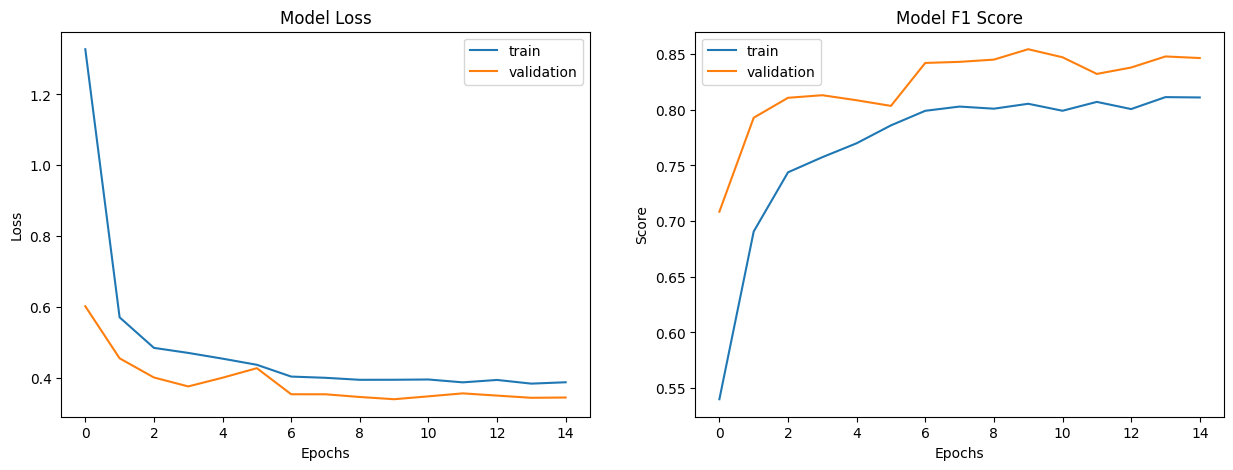

In [ ]:
evaluate_model_train(history_BM)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
              precision    recall  f1-score   support

      benign       0.77      0.85      0.80       396
   malignant       0.93      0.88      0.90       870

    accuracy                           0.87      1266
   macro avg       0.85      0.87      0.85      1266
weighted avg       0.88      0.87      0.87      1266



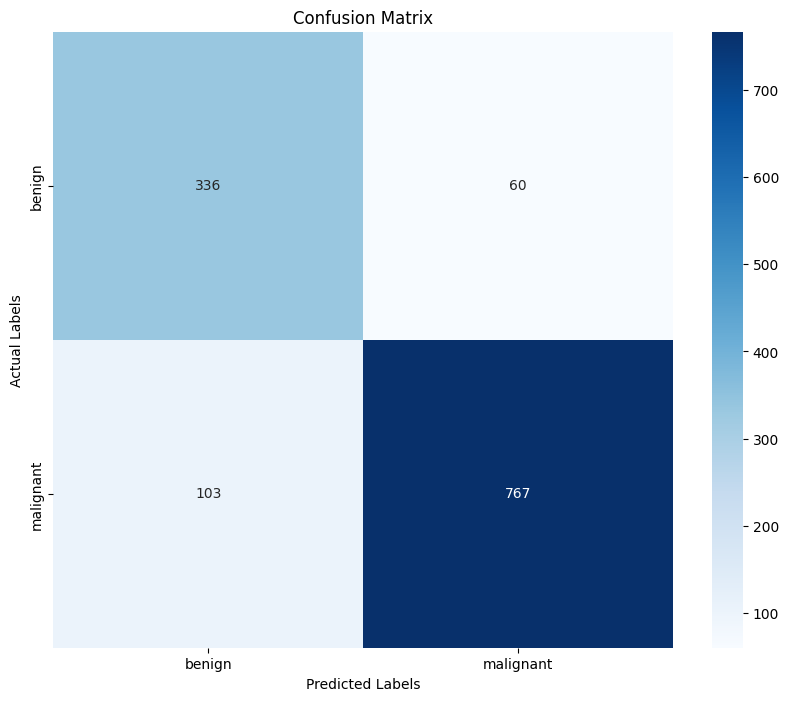

In [ ]:
evaluate_model_predictions(best_model, X_val_hp_a, y_binary_val_hp, y_labels, problem_type='single')

Using image data generator didn’t improve the results but now we have underfitting, so we will try to remove the dropouts to force overfitting. 

In [ ]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=shape_input)

# Freeze layers
for layer in base_model.layers[:-5]:
    layer.trainable = False

# Build the complete model
best_model = Sequential([base_model,
                         Flatten(),
                         Dense(128, activation='relu'),
                         Dense(64, activation='relu'),
                         Dense(2, activation='softmax')])

# Compile model
best_model.compile(optimizer= Adam(0.001), loss='categorical_crossentropy', metrics=['F1Score'])


In [ ]:
datagen = ImageDataGenerator(rotation_range=50,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True)

datagen.fit(X_train_hp_a)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=2, min_lr = 0.00001)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_BM = best_model.fit(datagen.flow(X_train_hp_a, y_binary_train_hp, batch_size=100), epochs=50, callbacks=list_callbacks,
                            validation_data=[X_val_hp_a, y_binary_val_hp], class_weight=class_weights_dict)

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 81s 1s/step - F1Score: 0.5776 - loss: 1.6454 - val_F1Score: 0.7487 - val_loss: 0.5355 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 32s 540ms/step - F1Score: 0.7741 - loss: 0.4591 - val_F1Score: 0.8056 - val_loss: 0.3760 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 537ms/step - F1Score: 0.7965 - loss: 0.4217 - val_F1Score: 0.8102 - val_loss: 0.4268 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 550ms/step - F1Score: 0.7988 - loss: 0.4100 - val_F1Score: 0.8424 - val_loss: 0.3283 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 542ms/step - F1Score: 0.8010 - loss: 0.4260 - val_F1Score: 0.8373 - val_loss: 0.3723 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 31s 540ms/step - F1Score: 0.8316 - loss: 0.3536 - val_F1Score: 0.8011 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 41s 538ms/step - F1Score: 0.8169 - loss: 0.3646 - val_F1Sco

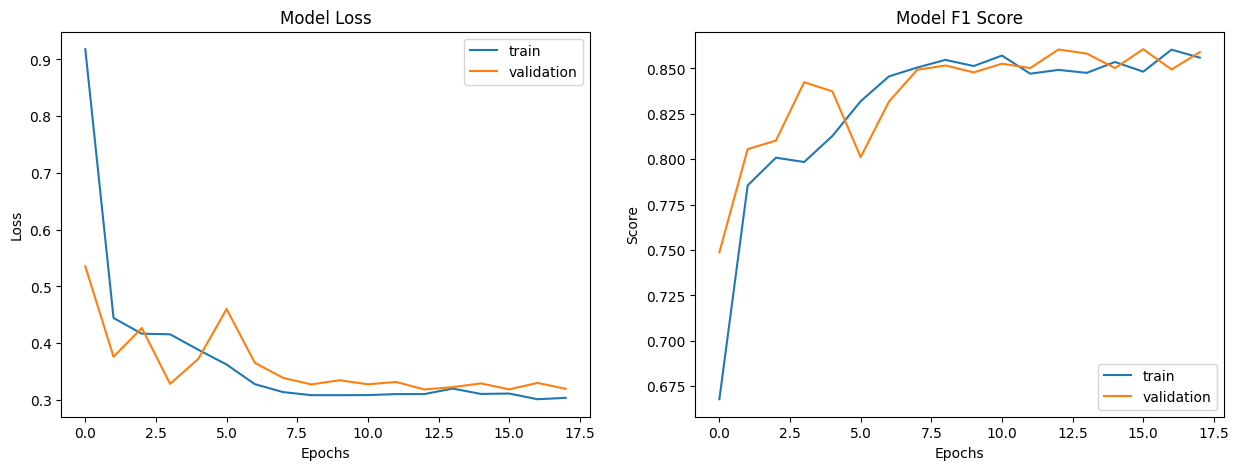

In [ ]:
evaluate_model_train(history_BM)

40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 221ms/step
              precision    recall  f1-score   support

      benign       0.76      0.88      0.81       396
   malignant       0.94      0.87      0.91       870

    accuracy                           0.88      1266
   macro avg       0.85      0.88      0.86      1266
weighted avg       0.88      0.88      0.88      1266



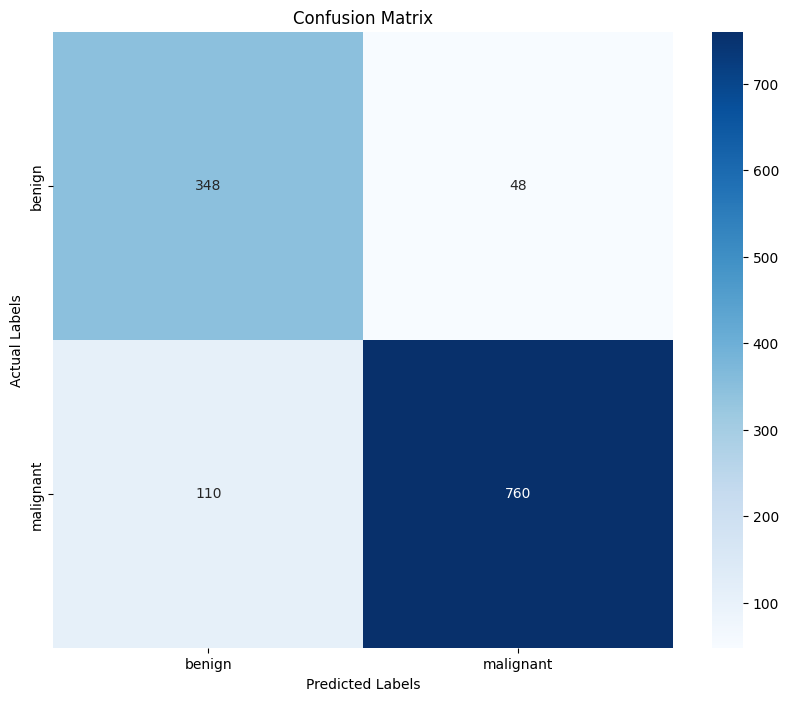

In [ ]:
evaluate_model_predictions(best_model, X_val_hp_a, y_binary_val_hp, y_labels, problem_type='single')

Now we can conclude that image data generator didn’t improve the results, not reaching even the previous result of 0.87 F1 score in the validation, so we won’t use image data generator going forward.

### Best Binary model with Magnitude.

We will try to implement our best model, but now in the dense layer part it will receive the feature maps extracted from the images and, additionally, the magnitude of the images.

In [ ]:
# Model Advance

# Inputs
input_tensor = Input(shape=shape_input, name='image')
input_magnitude = Input(shape=shape_mag, name='magnitude')

PT_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze layers
for layer in PT_model.layers[:-5]:
    layer.trainable = False

#Flatten
PT_output = PT_model.output
flat = Flatten(name='Flat')(PT_output)
flat = concatenate([flat, input_magnitude], axis=1, name='Flat_BI')

# Build the complete model
BI_dense = Dropout(0.4, name='BI_dropout0')(flat)
BI_dense = Dense(128, activation='relu',name="BI_dense1")(BI_dense)
BI_dense = Dropout(0.3, name='BI_dropout1')(BI_dense)
BI_dense = Dense(64, activation='relu',name="BI_dense2")(BI_dense)
BI_output = Dense(2, activation='softmax',name="BI_output")(BI_dense)

# build de model
model_Bi_Adv = Model([input_tensor,input_magnitude], BI_output)

model_Bi_Adv.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['F1Score'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
x_data = {'image' : X_train_hp_a,
            'magnitude' : Mag_train_hp}

val_data_dic_in = {'image' : X_val_hp_a,
                    'magnitude' : Mag_val_hp}

In [ ]:
sample_weight_train_hp_Bi = np.array(list(map(class_weights_dict.get, np.argmax(y_binary_train_hp, axis=1))))
sample_weight_train_hp_Bi[:10]

array([0.72840302, 0.72840302, 0.72840302, 0.72840302, 1.59455645,
       0.72840302, 0.72840302, 0.72840302, 1.59455645, 1.59455645])

In [ ]:
history_BM_adv = model_Bi_Adv.fit(x_data,
                          y_binary_train_hp,
                          batch_size= 100,
                          epochs=50,
                          callbacks=list_callbacks,
                          validation_data=[val_data_dic_in, y_binary_val_hp],
                          sample_weight=sample_weight_train_hp_Bi
                          )

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 78s 921ms/step - F1Score: 0.5263 - loss: 1.6536 - val_F1Score: 0.7592 - val_loss: 0.4435 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 149ms/step - F1Score: 0.7207 - loss: 0.5483 - val_F1Score: 0.8237 - val_loss: 0.3910 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 175ms/step - F1Score: 0.7830 - loss: 0.4402 - val_F1Score: 0.8343 - val_loss: 0.3304 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - F1Score: 0.8294 - loss: 0.3632 - val_F1Score: 0.8480 - val_loss: 0.3121 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 169ms/step - F1Score: 0.8616 - loss: 0.3058 - val_F1Score: 0.8557 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - F1Score: 0.8584 - loss: 0.3050 - val_F1Score: 0.8673 - val_loss: 0.2914 - learning_rate: 0.0010
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 11s 172ms/step - F1Score: 0.8788 - loss: 0.2679 - val_F1Sc

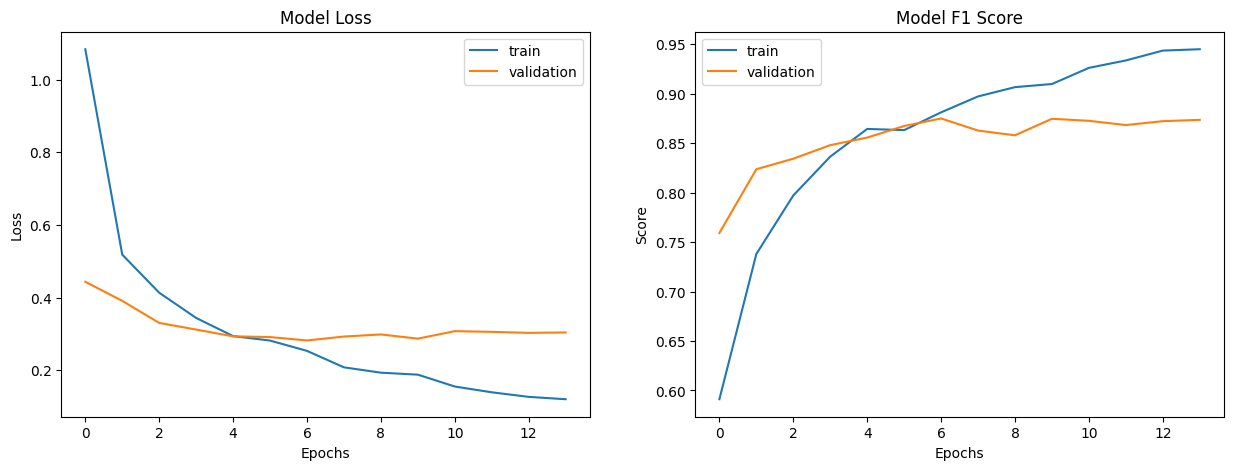

In [ ]:
evaluate_model_train(history_BM_adv)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
              precision    recall  f1-score   support

      benign       0.79      0.88      0.83       396
   malignant       0.94      0.89      0.92       870

    accuracy                           0.89      1266
   macro avg       0.87      0.89      0.87      1266
weighted avg       0.89      0.89      0.89      1266



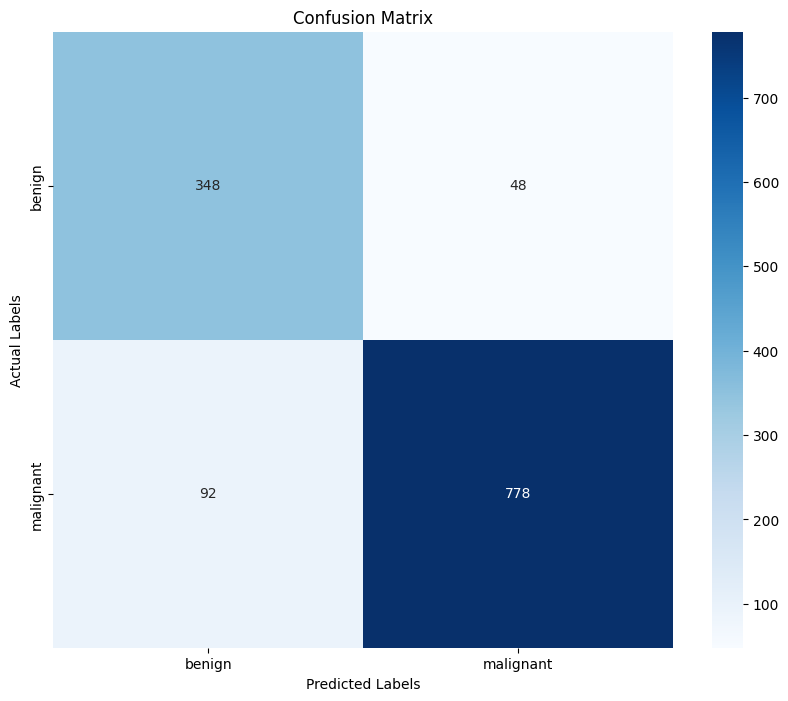

In [ ]:
evaluate_model_predictions(model=model_Bi_Adv,
                           X_array=val_data_dic_in,
                           y_array_1=y_binary_val_hp,
                           y_label_1=y_labels,
                           problem_type='single')

Even with the magnitude as input we don’t reach the benchmark of 0.88 F1 in validation, because of that we will use our benchmark model for the binary classification.

### Benchmark model

In [ ]:
# Model Advanced

# Inputs
input_tensor = Input(shape=shape_input, name='image')
input_magnitude = Input(shape=shape_mag, name='magnitude')

# Conv + Pool
Conv_3_3 = Conv2D(32, (3,3), activation='relu', name='Conv_3x3_1')(input_tensor)
Conv_3_3 = Conv2D(32, (3,3), activation='relu', name='Conv_3x3_2')(Conv_3_3)

Pool_2_2 = MaxPooling2D((2,2), name='Pool_2x2')(Conv_3_3)

# inception modules
block_1 = inception_module(Pool_2_2, n_f_1x1=64, n_f_3x3_r =16, n_f_3x3=64, n_f_5x5_r=16, n_f_5x5=64, n_f_1x1_end=64, name='IB1')

Pool2_2_2 = MaxPooling2D((2,2), name='Pool2_2x2')(block_1)

# Conv + Pool
Conv2_3_3 = Conv2D(64, (3,3), activation='relu', name='Conv2_3x3_1')(Pool2_2_2)
Conv2_3_3 = Conv2D(64, (3,3), activation='relu', name='Conv2_3x3_2')(Conv2_3_3)

Pool3_2_2 = MaxPooling2D((3,3), name='Pool3_2x2')(Conv2_3_3)

# Flaten bin
flat = Flatten(name='Flat')(Pool3_2_2)
flat = concatenate([flat, input_magnitude], axis=1, name='Flat_Bi')

# Dense Bi
Bi_dense = Dense(2048, activation='relu', name='Bi_dense0')(flat)
Bi_dense = Dropout(0.5, name='Bi_dropout0')(Bi_dense)
Bi_dense = Dense(1024, activation='relu', name='Bi_dense1')(Bi_dense)
Bi_dense = Dropout(0.5, name='Bi_dropout1')(Bi_dense)
Bi_dense = Dense(512, activation='relu', name='Bi_dense3')(Bi_dense)
Bi_dense = Dropout(0.4, name='Bi_dropout3')(Bi_dense)
Bi_output = Dense(2, activation='softmax', name='Bi_output')(Bi_dense)


# build de model
model_EX_Adv = Model([input_tensor,input_magnitude], Bi_output)

model_EX_Adv.compile(optimizer='adam',
                 loss='categorical_crossentropy',
                 metrics=['F1Score'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
LR_ajust = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)
list_callbacks = [early_stop, LR_ajust]

In [ ]:
history_EX_adv = model_EX_Adv.fit(x_data,
                          y_binary_train_hp,
                          batch_size= 100,
                          epochs=50,
                          callbacks=list_callbacks,
                          validation_data=[val_data_dic_in, y_binary_val_hp],
                          sample_weight=sample_weight_train_hp_Bi
                          )

Epoch 1/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 70s 924ms/step - F1Score: 0.5505 - loss: 0.7347 - val_F1Score: 0.7893 - val_loss: 0.4554 - learning_rate: 0.0010
Epoch 2/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 26s 198ms/step - F1Score: 0.7605 - loss: 0.5336 - val_F1Score: 0.6622 - val_loss: 0.7083 - learning_rate: 0.0010
Epoch 3/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 198ms/step - F1Score: 0.7471 - loss: 0.5322 - val_F1Score: 0.7038 - val_loss: 0.6017 - learning_rate: 0.0010
Epoch 4/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - F1Score: 0.7730 - loss: 0.4943 - val_F1Score: 0.6387 - val_loss: 0.6530 - learning_rate: 0.0010
Epoch 5/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 20s 197ms/step - F1Score: 0.7404 - loss: 0.5031 - val_F1Score: 0.8465 - val_loss: 0.3963 - learning_rate: 1.0000e-04
Epoch 6/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 200ms/step - F1Score: 0.8189 - loss: 0.4457 - val_F1Score: 0.8692 - val_loss: 0.3690 - learning_rate: 1.0000e-04
Epoch 7/50
51/51 ━━━━━━━━━━━━━━━━━━━━ 10s 201ms/step - F1Score: 0.8218 - loss: 0.4389 

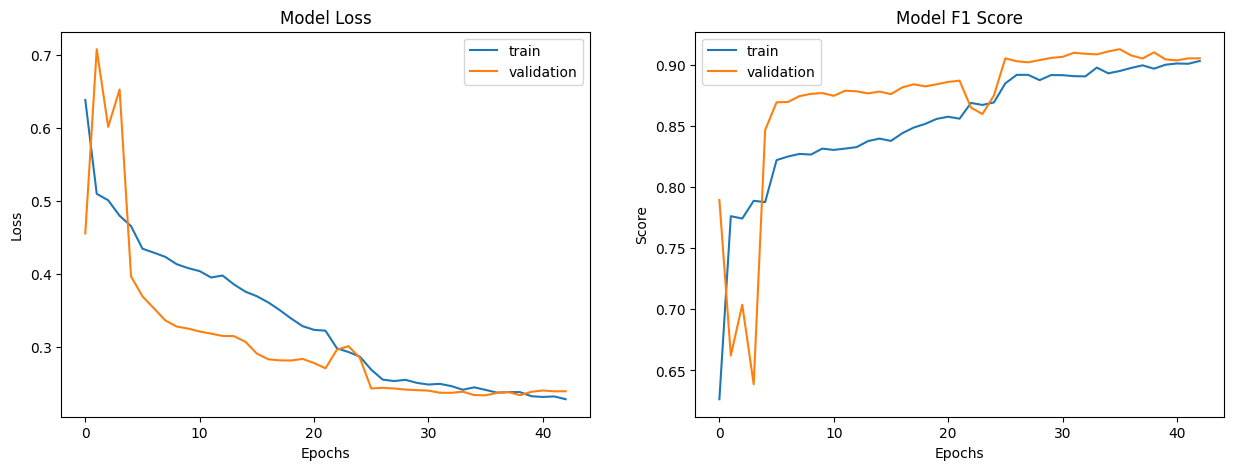

In [ ]:
evaluate_model_train(history_EX_adv)

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
              precision    recall  f1-score   support

      benign       0.85      0.91      0.88       396
   malignant       0.96      0.93      0.94       870

    accuracy                           0.92      1266
   macro avg       0.91      0.92      0.91      1266
weighted avg       0.93      0.92      0.92      1266



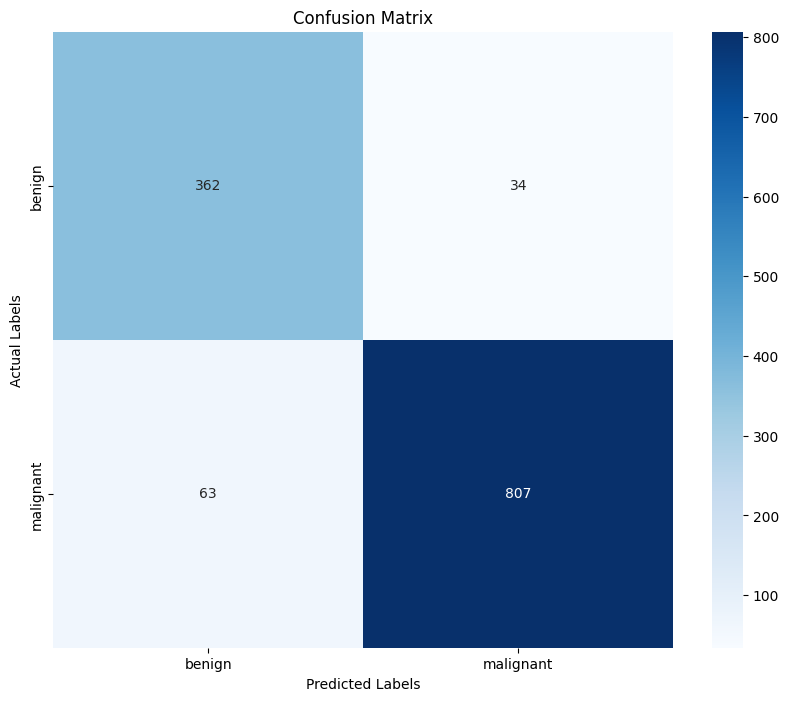

In [ ]:
evaluate_model_predictions(model=model_EX_Adv,
                           X_array=val_data_dic_in,
                           y_array_1=y_binary_val_hp,
                           y_label_1=y_labels,
                           problem_type='single')

Using our benchmark model only for the binary classification, it achieves better results than combining it with the multiclass, obtaining an F1 score in validation of 0.91 (the benchmark was 0.88 F1 score), with no overfitting. So this is our best model so far.

## Final Evaluation on Test

In [ ]:
X_test_data = {"image": X_test_a,
               "magnitude": Mag_test}

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step
              precision    recall  f1-score   support

      benign       0.81      0.89      0.85       496
   malignant       0.95      0.91      0.92      1086

    accuracy                           0.90      1582
   macro avg       0.88      0.90      0.89      1582
weighted avg       0.90      0.90      0.90      1582



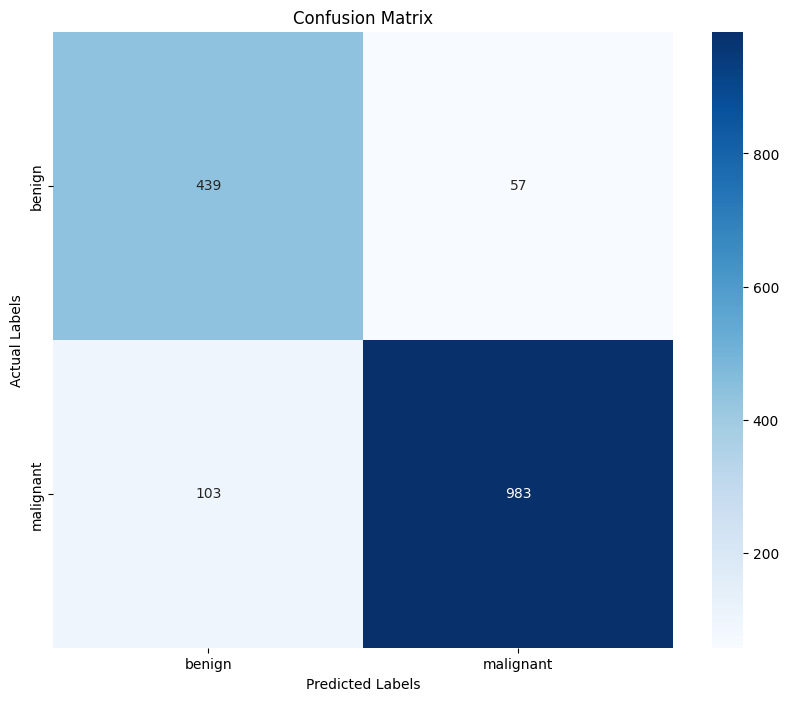

In [ ]:
evaluate_model_predictions(model_EX_Adv, X_test_data, y_binary_test, y_labels, problem_type='single' )


Now after testing our best model on the test set, we confirm that the benchmark was passed (0.85 F1 score on test set), achieving a F1 score of 0.89, and a weighted one of 0.90. 

Obviously the weighted average is slightly higher, because, as expected, the class our model finds easiest to classify is the majority class (malignant), which inflates the weighted average when comparing to the macro average as it is ~2 times more common than the benign class.

Interestingly, the model predictions have very few false positives (only 57 cases of 1582, ~3.6%  of cases), in a real context this is good since predicting a benign cancer as malignant can cause the patients to get a false, and much more severe, diagnosis.

On the other hand, the model predictions contain 103 false negatives, this is not ideal, as in a real context this means these malignant cancer cases would go undetected. However, 103 out of 1582 is only ~6.5%, which means this is not an extremely common scenario.


## Next Step
Go to the Experiment notebooks (if you already saw the Multiclass one) to see the process of trying to improve our best models.